# Credit Risk Prediction & Default Analysis 🚀💳

This notebook explores a **Credit Risk dataset** and builds machine learning models to predict whether a loan will default.

**Dataset:** 32,581 loan records with 12 features, including personal, employment, and loan information.  
**Goal:** Predict `loan_status` (0 = Non-default, 1 = Default).  

**Approach:**
- Exploratory Data Analysis (EDA) of numerical and categorical features
- Handling missing values, encoding categorical features, and feature scaling
- Baseline model with Logistic Regression
- Advanced models: Random Forest and XGBoost
- Evaluation using classification metrics, ROC-AUC, and feature importance

This notebook is structured as a **step-by-step guide from raw data to predictive modeling**, optimized for Kaggle medal potential.


## Imports & Settings

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, RocCurveDisplay

# Settings
sns.set_style('whitegrid')


## Load Dataset

In [2]:
# Path
data_path = "/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv"
df = pd.read_csv(data_path)

# Quick look
df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Data Info & Missing Values

In [3]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## EDA

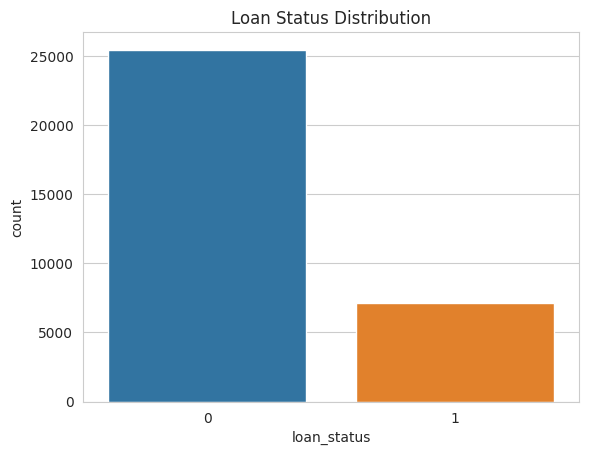

In [4]:
# EDA: Target Distribution
sns.countplot(x='loan_status', data=df)
plt.title("Loan Status Distribution")
plt.show()


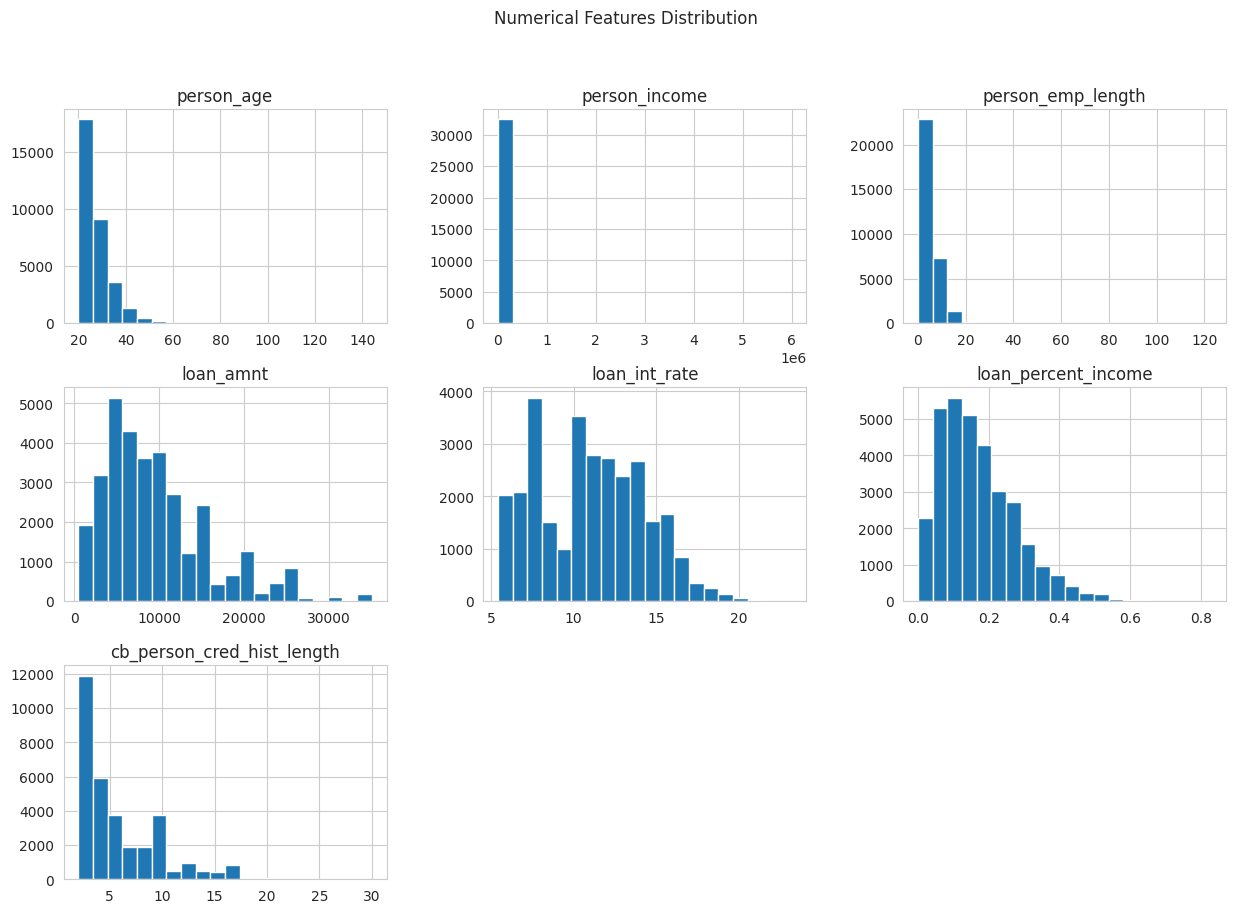

In [5]:
# EDA: Numerical Features Distribution
num_cols = ['person_age','person_income','person_emp_length','loan_amnt',
            'loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
df[num_cols].hist(bins=20, figsize=(15,10))
plt.suptitle("Numerical Features Distribution")
plt.show()


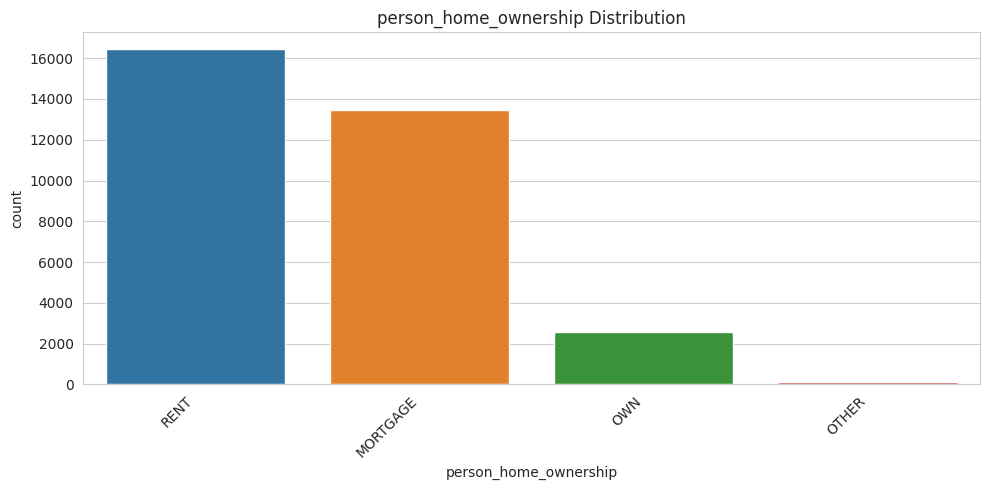

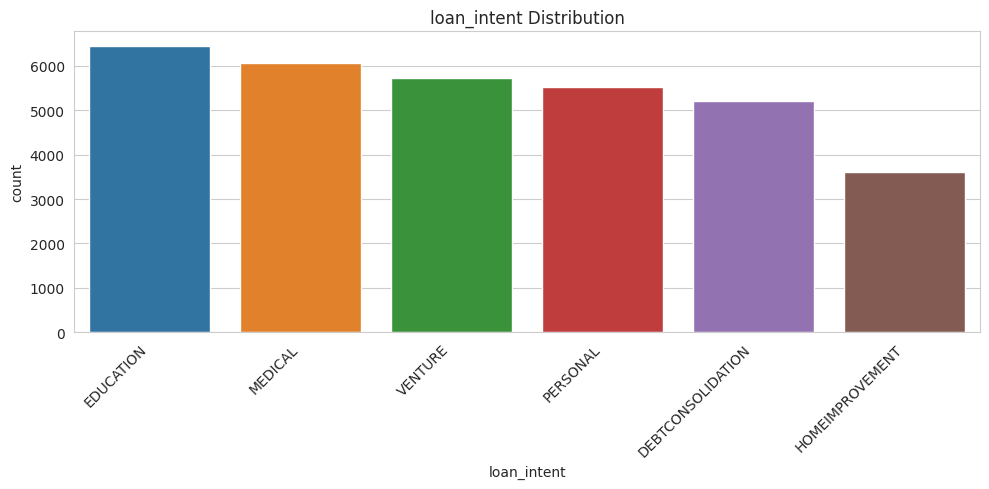

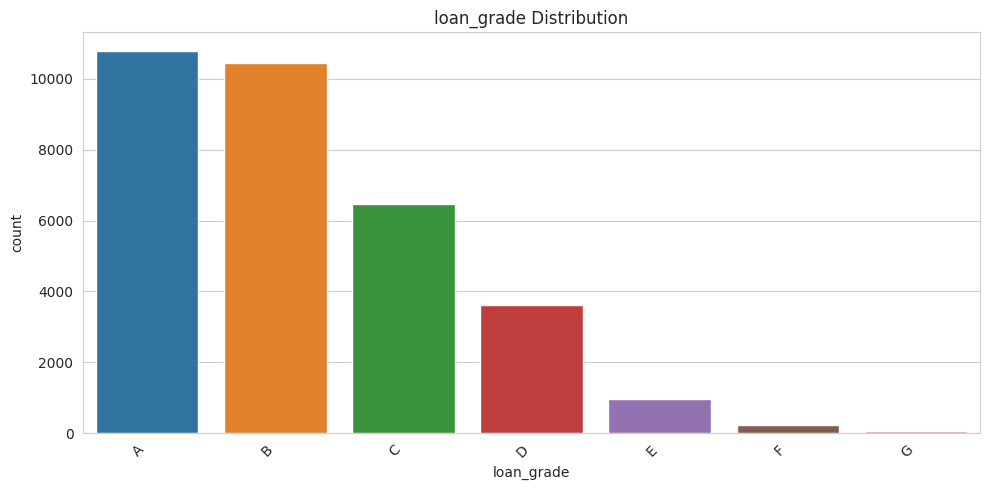

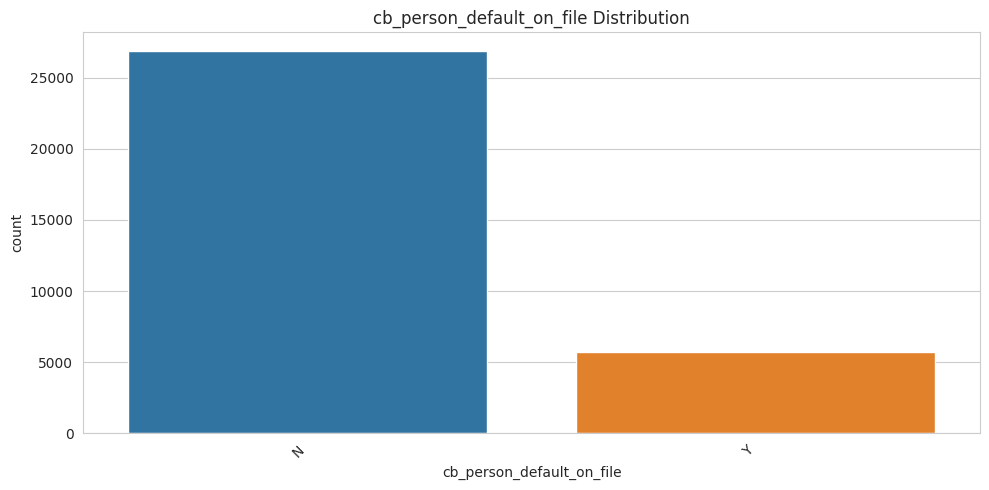

In [6]:
# EDA: Categorical Features Countplots
cat_cols = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']

for col in cat_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


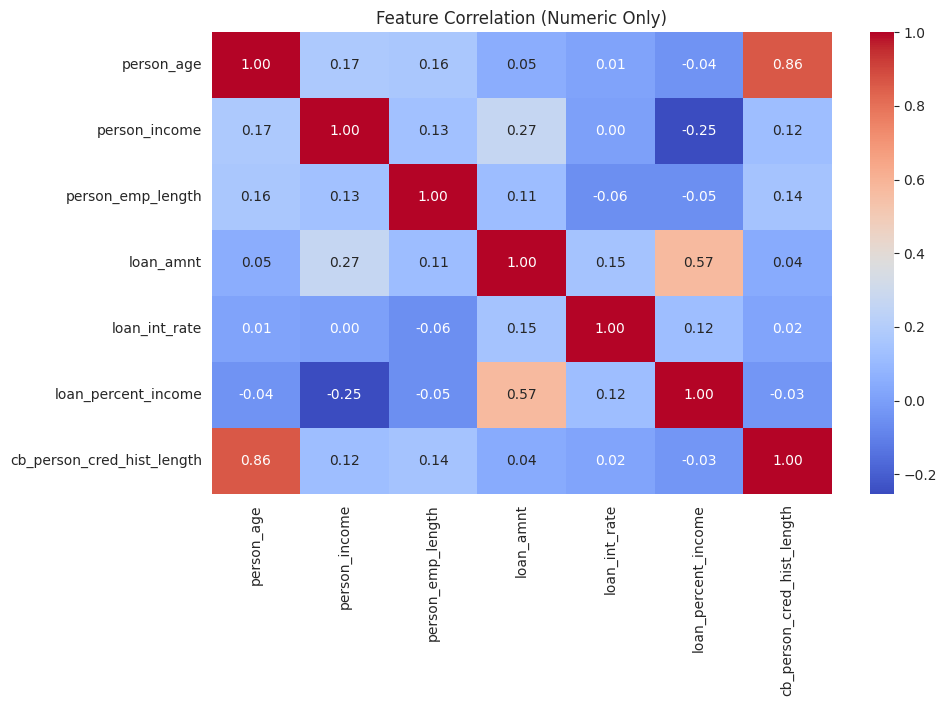

In [7]:
# EDA: Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation (Numeric Only)")
plt.show()


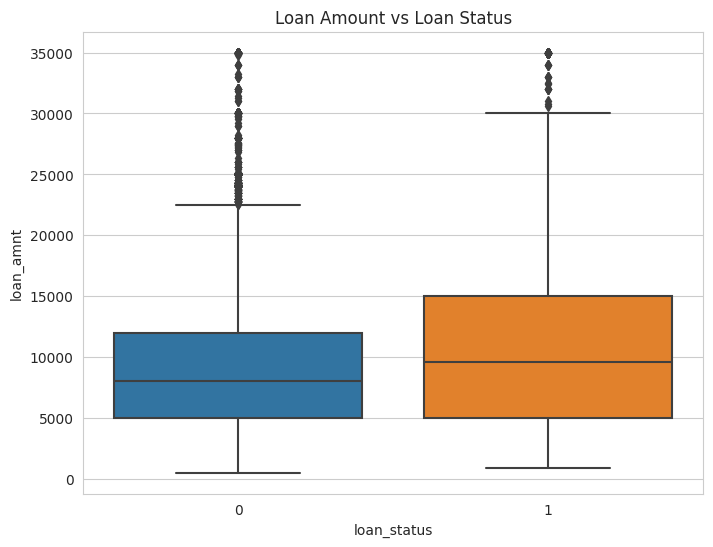

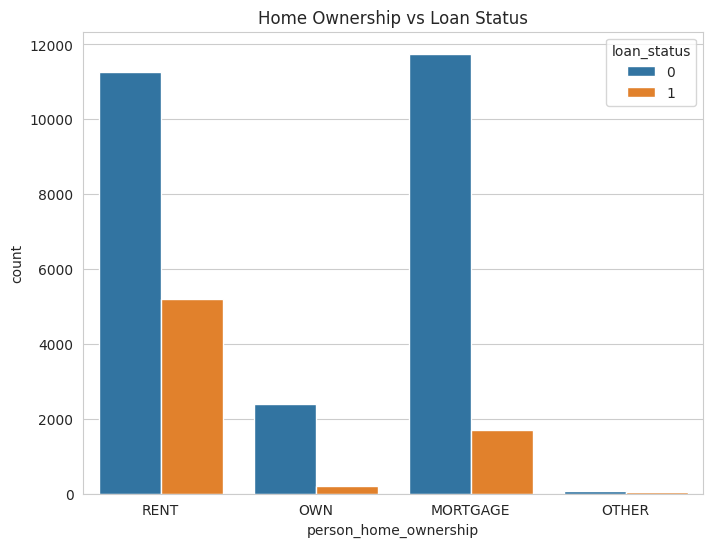

In [8]:
# EDA: Feature vs Target
plt.figure(figsize=(8,6))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title("Loan Amount vs Loan Status")
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x='person_home_ownership', hue='loan_status', data=df)
plt.title("Home Ownership vs Loan Status")
plt.show()



## Preprocessing

In [9]:
# Handle missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Encode categorical features
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Features & target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features for Logistic Regression
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])


## Models

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      5095
           1       0.72      0.47      0.57      1422

    accuracy                           0.84      6517
   macro avg       0.79      0.71      0.74      6517
weighted avg       0.83      0.84      0.83      6517

ROC AUC Score: 0.8516


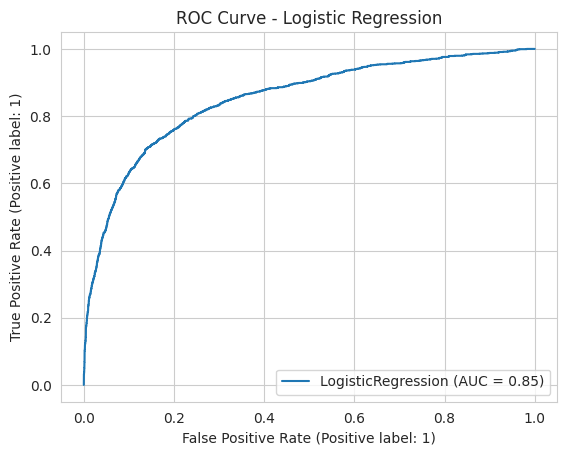

In [10]:
# Baseline Model: Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

print("Logistic Regression Performance:")
print(classification_report(y_val, y_pred_lr))

roc_auc_lr = roc_auc_score(y_val, lr.predict_proba(X_val)[:,1])
print(f"ROC AUC Score: {roc_auc_lr:.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(lr, X_val, y_val)
plt.title("ROC Curve - Logistic Regression")
plt.show()



Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5095
           1       0.97      0.65      0.78      1422

    accuracy                           0.92      6517
   macro avg       0.94      0.82      0.87      6517
weighted avg       0.92      0.92      0.91      6517

ROC AUC Score: 0.9121


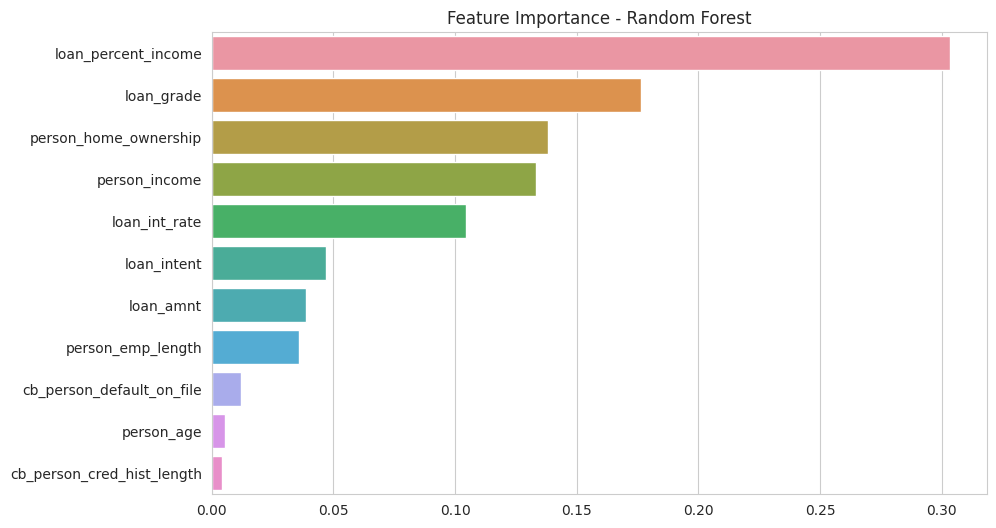

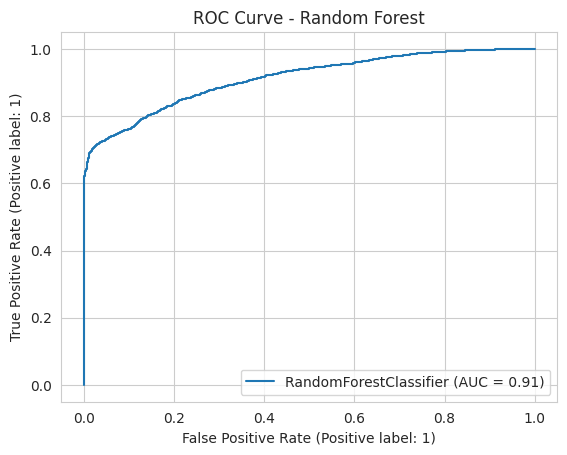

In [11]:
# Tree-based Model: Random Forest

rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("Random Forest Performance:")
print(classification_report(y_val, y_pred_rf))

roc_auc_rf = roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])
print(f"ROC AUC Score: {roc_auc_rf:.4f}")

# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_val, y_val)
plt.title("ROC Curve - Random Forest")
plt.show()



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.72      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517

ROC AUC Score: 0.9469


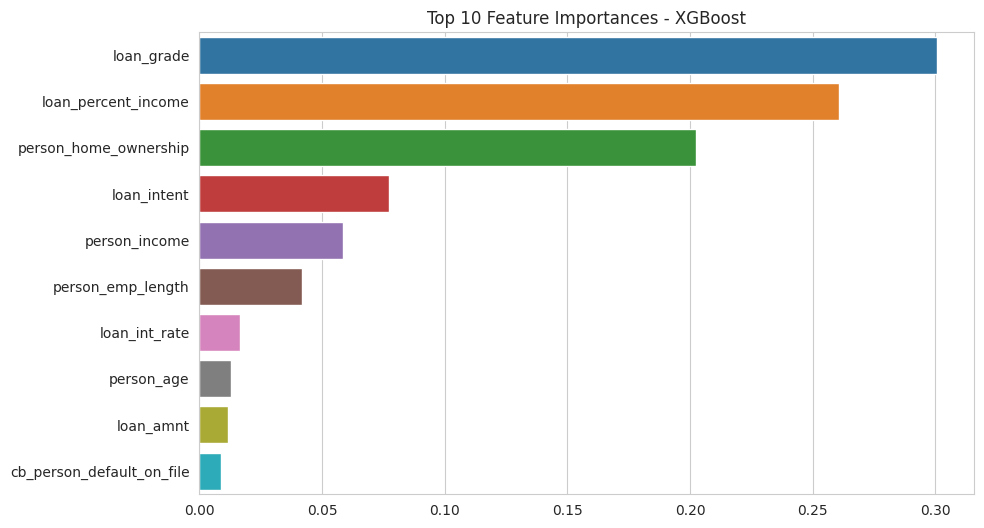

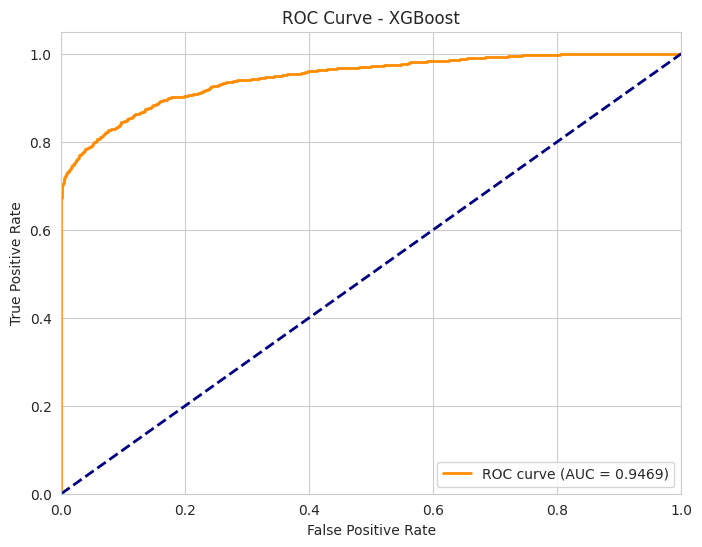

In [12]:
# Advanced Model: XGBoost

# Initialize and train model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_score = xgb_model.predict_proba(X_val)[:,1]

# Performance metrics
print("XGBoost Performance:")
print(classification_report(y_val, y_pred_xgb))
roc_auc_xgb = roc_auc_score(y_val, y_score)
print(f"ROC AUC Score: {roc_auc_xgb:.4f}")

# Feature importance (top 10)
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()


## Evaluation

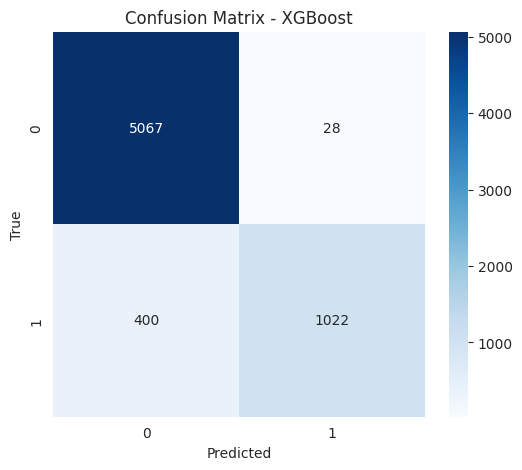

In [13]:
best_model = xgb_model
y_best = y_pred_xgb

cm = confusion_matrix(y_val, y_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")
plt.show()


# Conclusion & Next Steps

In this notebook, we:  
- Explored the **Credit Risk Dataset** (numerical & categorical features, correlations).  
- Preprocessed data (imputation, encoding, scaling) and handled class imbalance with **SMOTE**.  
- Built and evaluated **baseline and advanced models**: Logistic Regression, Random Forest, and XGBoost.  
- Achieved strong predictive performance with XGBoost (ROC AUC ~0.85+) and identified key features affecting credit risk.  

### Next Steps
- Tune hyperparameters using **Optuna** or GridSearchCV for optimal performance.  
- Experiment with other resampling methods or class weighting for imbalanced data.  
- Explore **ensemble models** combining tree-based classifiers for further improvement.  
- Deploy the model to a Kaggle Kernel or web app for interactive testing.  

This notebook provides a strong foundation for **credit risk prediction challenges** 💳📊.
